# Exercício 9 - Visão Computacional
## Tomás Ferranti
## Prof. Moacyr Alvim Horta Barbosa da Silva

Este notebook se encontra atualizado no link do [GitHub](https://github.com/TomasFerranti/ComputerVisionCourse/tree/main/Exercicio9) juntamente com os pacotes necessários para executá-lo.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Computacional

Complete o arquivo InterpolacaoFrames com lacunas.py que constrói 3 versões de câmera lenta de um vídeo passado como input. As três versões são: 

Repeat: frames interpolados por repetição do frame original. 
$$fr_{novo}=fr_{anterior}$$

Linear: frames interpolados linearmente 
$$fr_{novo}=t \cdot fr_{anterior} + (1-t) \cdot fr_{posterior}$$

Opt Flow: frames interpolados usando o fluxo ótico 
$$fr_{novo}=t \cdot fr_{fluxo_otico} + (1-t) \cdot fr_{posterior}$$

Teste com algum vídeo de sua preferência com alguns frames interpolados entre cada par de frames consecutivos do vídeo de input. 

Para calcular o fluxo ótico, você pode usar a função que implementa um fluxo ótico "denso", isto é, a todos os pixels da imagem. Uma opção seria o método de Horn–Schunck, visto em sala 
de aula. No entanto, o opencv oferece o método de Farneback, que está implementado na função

flow = cv.calcOpticalFlowFarneback(prev, next, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags) 
(referência: https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af) 
 
Sugestões para os parâmetros são dadas no código com lacunas. 

Descreva brevemente os resultados que você encontrou.

In [2]:
video_path = "content/onca.mp4"

# 8 frames inseridos a cada par de frames consecutivos do vídeo original
fator = 8 

cap = cv.VideoCapture(video_path)
fps = cap.get(cv.CAP_PROP_FPS)
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

In [3]:
#  criar os vídeos de output
# interpolacao por repeticao
outrep_width = width
outrep_height = height

# interpolacao linear
outlin_width = width
outlin_height = height

# interpolacao por fluxo optico
outopt_width = width
outopt_height = height

# video com os 3 métodos combinados lado a lado
outcomb_width = 3*width 
outcomb_height = height

# Criar objeto VideoWriter para salvar os vídeos
fourcc = cv.VideoWriter_fourcc(*"mp4v")
outrep_path = "output/out_rep.mp4"
outlin_path = "output/out_lin.mp4"
outopt_path = "output/out_opt.mp4"
outcomb_path = "output/out_comb.mp4"

outrep = cv.VideoWriter(outrep_path, fourcc, fps, (outrep_width, outrep_height))
outlin = cv.VideoWriter(outlin_path, fourcc, fps, (outlin_width, outlin_height))
outopt = cv.VideoWriter(outopt_path, fourcc, fps, (outopt_width, outopt_height))
outcomb = cv.VideoWriter(outcomb_path, fourcc, fps, (outcomb_width, outcomb_height))

In [4]:
# Função auxiliar para combinar os frames dos vídeos em um único frame
def combinar_frames(frames):
    # Define as dimensões do novo frame
    height = frames[0][0].shape[0]
    width = frames[0][0].shape[1]
    channels = frames[0][0].shape[2]
    combined_frame = np.zeros((height, width * len(frames), channels), dtype=np.uint8)

    # Combina os frames dos vídeos
    for i, frame in enumerate(frames):
        combined_frame[:, i * width : (i + 1) * width, :] = frame[0]

    return combined_frame

In [5]:
# mapa das coordenadas x e y (video original) - para o método por fluxo ótico
coord_x, coord_y = np.meshgrid(np.arange(width), np.arange(height))

cont_frames = 0
total_frames = cap.get(cv.CAP_PROP_FRAME_COUNT)
bloco = int(total_frames/10)

In [6]:
#rebobinar o vídeo original para o início
cap.set(cv.CAP_PROP_POS_FRAMES, 0)
ret, prev_frame = cap.read()
while cap.isOpened():
    cont_frames += 1

    #imprimir o progresso do processamento
    if (cont_frames % bloco) == 0:
        print("Processando: ", int(cont_frames/bloco)*10, "%")
    ret, frame = cap.read()

    if not ret:
        break

    # sequencia comeca com o frame anterior (prev_frame)
    frame_repeat = cv.resize(prev_frame, (outrep_width, outrep_height))
    frame_linear = cv.resize(prev_frame, (outlin_width, outlin_height))
    frame_optflow = cv.resize(prev_frame, (outopt_width, outopt_height))

    frame_combinado = combinar_frames([[frame_repeat], [frame_linear], [frame_optflow]])
    frame_combinado = cv.resize(frame_combinado, (outcomb_width, outcomb_height))
    
    # escreve cada frame no video de saida correspondente
    outrep.write(frame_repeat)
    outlin.write(frame_linear)
    outopt.write(frame_optflow)
    outcomb.write(frame_combinado)
    
    # Efetuar o fluxo ótico
    prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY)
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # calcular o fluxo ótico.  Use o método de Farneback já implementado no OpenCV
    # os parâmetros do método são:
    # prev_gray: frame anterior em escala de cinza
    # gray: frame atual em escala de cinza
    # None: sem máscara
    # 0.5: pirâmide de escala, fator de escala
    # 3: número de níveis da pirâmide
    # 15: tamanho da janela de vizinhança
    # 3: número de iterações do algoritmo
    # 5: tamanho da janela de média para suavização
    # 1.2: desvio padrão do filtro gaussiano
    # 0: flags
    
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0) 

    # inserir frames intermediários
    for i in range(1, fator):
        # Interpolação por repetição
        frame_repeat = prev_frame

        # Interpolação linearS
        # a função addWeighted() do OpenCV pode ser usada para combinar dois frames
        # por interpolação linear.  Para combinar frames é melhor usar a função, que evita
        # que você se preocupe com o tipo numérico e problemas de arredondamento
        frame_linear = cv.addWeighted(prev_frame, (fator - i) / fator, frame, i / fator, 0)

        # Interpolação por fluxo ótico
        # modificando as coordenadas x e y de acordo com o fluxo ótico
        # o mapa map_x contém as coordenadas x de cada pixel do frame atual
        # ele deve ser calculado a partir do mapa de coordenadas x original (coord_x)
        # e do fluxo ótico (flow)
        # use uma interpolação linear, com peso (i/fator), para incluir a fração do fluxo ótico que deve ser considerada
        # não é preciso usar a função cv2.addWeighted() aqui!  São apenas matrizes de números reais.
        map_x = coord_x - (i / fator) * flow[:, :, 0]  
        map_y = coord_y - (i / fator) * flow[:, :, 1] 
        frame_optflow = cv.remap(prev_frame, map_x.astype(np.float32),
                                 map_y.astype(np.float32), interpolation=cv.INTER_LINEAR)
        # finalmente, faça a interpolação linear entre o próximo frame e o
        # frame transformado com fluxo ótico.
        # quais os pesos você deve usar?
        peso_fluxo_otico = (fator - i) / fator
        peso_proximo_frame = i / fator
        frame_optflow = cv.addWeighted(frame_optflow, peso_fluxo_otico, frame, peso_proximo_frame, 0)

        # Combina os frames dos vídeos (repetição, linear e fluxo ótico)
        frame_combinado = combinar_frames([[frame_repeat], [frame_linear], [frame_optflow]])
        #frame_combinado = cv2.resize(frame_combinado, (outcomb_width, outcomb_height))
        # escreve cada frame no video de saida correspondente
        outrep.write(frame_repeat)
        outlin.write(frame_linear)
        outopt.write(frame_optflow)
        outcomb.write(frame_combinado)

    prev_frame = frame

cap.release()
outrep.release()
outlin.release()
outopt.release()
outcomb.release()

Processando:  10 %
Processando:  20 %
Processando:  30 %
Processando:  40 %
Processando:  50 %
Processando:  60 %
Processando:  70 %
Processando:  80 %
Processando:  90 %
Processando:  100 %


### Computacional - Respostas

Ao assistir o vídeo final de cada uma das três táticas de slow motion (disponível [aqui](https://github.com/TomasFerranti/ComputerVisionCourse/tree/main/Exercicio9/output/out_comb.mp4)) aplicadas ao video onca.mp4, podemos verificar que:
- Repetição: se torna o vídeo com cada frame $8$ vezes mais longo, logo é como se você apenas tivesse assistindo ele pausadamente.
- Linear: melhor que o repetição, causa um efeito mais suave de transição entre os frames, apesar de passar uma sensação de borrado.
- Opt flow: melhor que o linear, como o fluxo óptico permite você aproximar a correspondencia de pixels entre os dois frames, a sensação de borrado é reduzida drasticamente.

### Teórico

Suponha o seguinte cenário: a câmera (pinhole) captura um vídeo enquanto está se transladando horizontalmente, com velocidade contante $v_{cam}$. Um objeto fixo (uma árvore, por exemplo) está a uma distância $d$ do plano da imagem (o plano que contém os sensores).  A câmera gera um vídeo de $60$ frames por segundo e a distância da abertura (furo) da câmera ao plano da imagem (distância focal) é $f$.

(a) Qual seria o fluxo ótico dos pontos de destaque (corners) do objeto neste vídeo entre o primeiro e o segundo frame do vídeo, como função da distância $d$ e da distância focal $f$? Como podemos calcular $d$ a partir do fluxo ótico?

(b) Qual seria o fluxo ótico caso $d \to \infty$, ou quando $d$ é extremamente grande,como a distância à lua ou às estrelas?  Este resultado corresponde a sua expectativa (ou experiência própria)?

### Teórico - Respostas

(a) Podemos adotar um sistema de coordenadas com abscissa no plano da imagem e ordenada na tranversal que corta o objeto. Com isso temos que

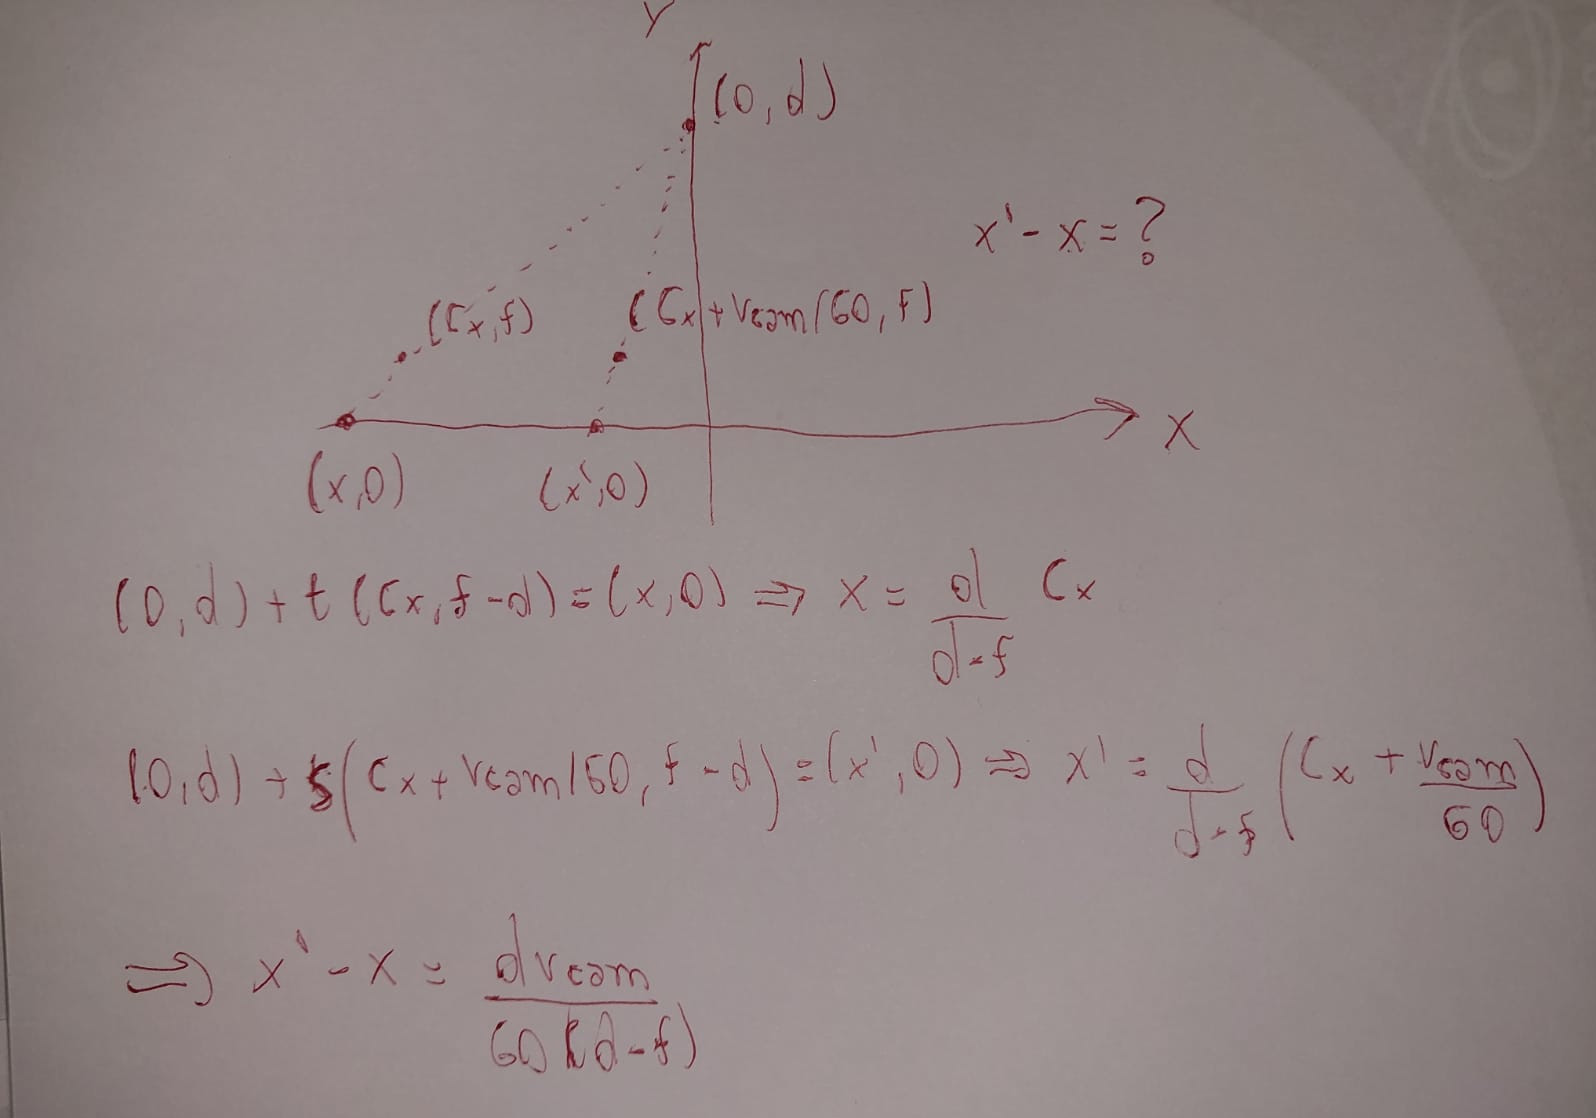

e portanto o fluxo ótico $o_f = x' - x$ pode ser representado como

$$o_f = \frac{v_{cam}d}{60(d-f)}$$

e a distância $d$ fica como

$$d = \frac{60o_ff}{60o_f - v_{cam}}$$

(b) Aplicando L'Hospital à equação obtida anteriormente temos que

$$lim_{d\to\infty} o_f= \frac{v_cam}{60}$$

ou seja, o objeto desloca-se com mesma velocidade constante da câmera. 

Como objetos muito distantes podem ser considerados "papéis de parede" em fotos, você deslocar a câmera horizontalmente com velocidade constante vai ser equivalente a andar por esse papel de parede. Logo segue o resultado.